# Loading data

In [86]:
import os

In [87]:
folder = {'test' :'PNP'}
statements = {'test' : {}}
print(os.getcwd())
ds_store_file_location = '/Users/aberkin/PNP/.DS_store'
if os.path.isfile(ds_store_file_location):
    os.remove(ds_store_file_location)

/Users/aberkin


In [88]:
folder = {'test' : 'PNP'}
statements = {'test' : {}}

In [89]:
for label, folder in folder.items():
    classes = os.listdir(folder)
    for classs in classes:
        att_files = os.listdir(os.path.join(folder, classs))
        for file in att_files:
            with open(os.path.join(folder, classs, file), 'r', encoding="utf8", errors='ignore') as att_file:
                statements[label].setdefault(classs, []).append(' '.join(att_file.readlines()))

# NLP process

In [90]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stemmer = PorterStemmer()
#there are other stemmers such as SnowBall stemmer. 
stop_words=set(stopwords.words("english"))
import en_core_web_sm
parser = en_core_web_sm.load()

In [91]:
spacyNLP = {}
for classs, text_list in statements['test'].items():
    spacyNLP[classs] = [parser(text) for text in text_list]

In [92]:
spacy_atts = {}
for classs, text_list in spacyNLP.items():
    spacy_atts[classs] = [list(text.sents) for text in text_list]

In [93]:
type(spacy_atts)

dict

In [94]:
def process_text_custom(text):
    sentences = list(parser(text).sents)
    stemmed_sentences = []
    for sentence in sentences:
        stemmed_sentences.append([stemmer.stem(token.text) for token in sentence if not token.is_stop | token.is_punct | token.is_space | token.is_digit| token.like_num])
    return [parser(' '.join(sentence)) for sentence in stemmed_sentences]

In [95]:
spacy_clean = {}
for classs, text_list in statements['test'].items():
    lst = []
    for text in text_list:      
        lst.append(process_text_custom(text))
    spacy_clean[classs] = lst

In [96]:
type(spacy_clean)

dict

In [97]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

In [98]:
plain_stat = []
for classs, value in spacy_clean.items():
    for statement in value:
        plain_stat.append(' '.join([x.text for x in statement]))

In [99]:
type(plain_stat)

list

In [100]:
vectorizer = TfidfVectorizer(stop_words='english') #min_df = 5

In [101]:
#Use SMOTE sampling, when necessary

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = '0.5',random_state=42)

# Machine learning algorithms

In [102]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
#from sklearn.pipeline import Pipeline # We need to use imblearn pipeline for re-sampling
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [103]:
statement_list = []
for classs, value in spacy_clean.items():
    for statement in value:
        statement_list.append((classs, ' '.join([x.text for x in statement])))

In [104]:
statement_df = pd.DataFrame(statement_list, columns=['classs', 'text'])

In [105]:
X_train, X_test, y_train, y_test = train_test_split(statement_df.text, statement_df.classs, test_size=0.15,random_state=3561)
print(len(X_train), len(X_test))

1074 190


In [106]:
#Naive Bayes
from sklearn.naive_bayes import MultinomialNB

In [108]:
clf_search = Pipeline([
      ('vect', TfidfVectorizer()),
      #('sm', SMOTE()), #use SMOTE, when necessary
      ('clf', MultinomialNB())
  ])
parameters = { 'vect__stop_words': ['english'],
                  'vect__strip_accents': ['unicode'],
                'vect__max_features' : [None, 1500, 5000],
                'vect__ngram_range': [(1,1), (1,2) ],
               # 'vect__max_df' : [(0.90), (0.80), (0.70)],
              #  'vect__min_df' : [(0.20), (0.10), (0.05)],
               'clf__alpha' : [0.01, 0.1, 1.0], 
               'clf__fit_prior' : ['True', 'False']
               }

In [80]:
%%time
grid = GridSearchCV(clf_search, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
grid.fit(X_train, y_train)

CPU times: user 523 ms, sys: 189 ms, total: 712 ms
Wall time: 5.14 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.01, 0.1, 1.0],
                         'clf__fit_prior': ['True', 'False'],
                         'vect__max_features': [None, 1500, 5000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': ['english'],
                         'vect__strip_accents': ['unicode']},
             scoring='accuracy')

In [84]:
print(grid.best_params_, grid.best_score_) #this shows the accuracy with the best fitting parameters
y_true, y_pred = y_test, grid.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

{'clf__alpha': 1.0, 'clf__fit_prior': 'True', 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english', 'vect__strip_accents': 'unicode'} 0.8576064382139148
              precision    recall  f1-score   support

      Nonper       0.74      0.85      0.79        72
         Per       0.90      0.82      0.86       118

    accuracy                           0.83       190
   macro avg       0.82      0.83      0.83       190
weighted avg       0.84      0.83      0.83       190



In [82]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)

print(conf_mat)
print(len(X_train), len(X_test))

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn, fp, fn, tp)

[[61 11]
 [21 97]]
1074 190
61 11 21 97


In [83]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

In [109]:
clf_search = Pipeline([
      ('vect', TfidfVectorizer()),
      ('clf', LogisticRegression())
  ])
parameters = { 'vect__stop_words': ['english'],
                  'vect__strip_accents': ['unicode'],
                'vect__max_features' : [None, 1500, 5000],
                'vect__ngram_range': [(1,1), (1,2) ],
                # 'vect__max_df' : [(0.90), (0.80), (0.70)],
                #'vect__min_df' : [(0.20), (0.10), (0.05)],
               'clf__random_state' : [0, 42, 100], 
               'clf__solver' : ['lbfgs', 'newton-cg', 'sag', 'saga'],
                'clf__multi_class' : ['multinomial', 'ovr']
               }

In [110]:
%%time
grid = GridSearchCV(clf_search, param_grid=parameters, scoring='accuracy', cv=10, n_jobs= -1)
grid.fit(X_train, y_train)

CPU times: user 2.81 s, sys: 459 ms, total: 3.27 s
Wall time: 17.1 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__multi_class': ['multinomial', 'ovr'],
                         'clf__random_state': [0, 42, 100],
                         'clf__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                         'vect__max_features': [None, 1500, 5000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': ['english'],
                         'vect__strip_accents': ['unicode']},
             scoring='accuracy')

In [111]:
from sklearn.metrics import accuracy_score

print(grid.best_params_, grid.best_score_) #this shows the accuracy with the best fitting parameters
y_true, y_pred = y_test, grid.predict(X_test)
print(metrics.classification_report(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

{'clf__multi_class': 'multinomial', 'clf__random_state': 0, 'clf__solver': 'lbfgs', 'vect__max_features': None, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english', 'vect__strip_accents': 'unicode'} 0.864122533748702
              precision    recall  f1-score   support

      Nonper       0.74      0.92      0.82        72
         Per       0.94      0.81      0.87       118

    accuracy                           0.85       190
   macro avg       0.84      0.86      0.84       190
weighted avg       0.87      0.85      0.85       190

0.8473684210526315


In [112]:
conf_mat = confusion_matrix(y_true, y_pred)

print(conf_mat)
print(len(X_train), len(X_test))

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn, fp, fn, tp)

[[66  6]
 [23 95]]
1074 190
66 6 23 95


In [113]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [114]:
clf_search = Pipeline([
      ('vect', TfidfVectorizer()),
      ('clf', RandomForestClassifier())
  ])
parameters = { 'vect__stop_words': ['english'],
                  'vect__strip_accents': ['unicode'],
                'vect__max_features' : [None, 1500, 5000],
                'vect__ngram_range': [(1,1), (1,2) ],
                #'vect__max_df' : [(0.90), (0.80), (0.70)],
               # 'vect__min_df' : [(0.20), (0.10), (0.05)],
               'clf__n_estimators' : [ 10, 100, 1000 ], 
               'clf__max_depth' : [ None, 5, 10, 100, 1000]
               }

In [115]:
%%time
grid = GridSearchCV(clf_search, param_grid=parameters, scoring='accuracy', cv=10, n_jobs= -1)
grid.fit(X_train, y_train)

CPU times: user 4.58 s, sys: 342 ms, total: 4.92 s
Wall time: 2min 5s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10, 100, 1000],
                         'clf__n_estimators': [10, 100, 1000],
                         'vect__max_features': [None, 1500, 5000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': ['english'],
                         'vect__strip_accents': ['unicode']},
             scoring='accuracy')

In [116]:
print(grid.best_params_, grid.best_score_) #this shows the accuracy with the best fitting parameters
y_true, y_pred = y_test, grid.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

{'clf__max_depth': 100, 'clf__n_estimators': 1000, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__strip_accents': 'unicode'} 0.851981654551748
              precision    recall  f1-score   support

      Nonper       0.74      0.82      0.78        72
         Per       0.88      0.82      0.85       118

    accuracy                           0.82       190
   macro avg       0.81      0.82      0.81       190
weighted avg       0.83      0.82      0.82       190



In [117]:
conf_mat = confusion_matrix(y_true, y_pred)

print(conf_mat)
print(len(X_train), len(X_test))

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(tn, fp, fn, tp)

[[59 13]
 [21 97]]
1074 190
59 13 21 97


In [118]:
#Decision Trees
from sklearn.tree import DecisionTreeClassifier

In [119]:
clf_search = Pipeline([
      ('vect', TfidfVectorizer()),
      ('clf', DecisionTreeClassifier())
  ])
parameters = { 'vect__stop_words': ['english'],
                  'vect__strip_accents': ['unicode'],
                'vect__max_features' : [None, 1500, 5000],
                'vect__ngram_range': [(1,1), (1,2) ],
                #'vect__max_df' : [(0.90), (0.80), (0.70)],
               # 'vect__min_df' : [(0.20), (0.10), (0.05)],
               'clf__min_samples_leaf' : [ 0.04, 0.06, 0.08, 1 ], 
               'clf__max_depth' : [ None, 5, 10, 100, 1000]
               }

In [120]:
%%time
grid = GridSearchCV(clf_search, param_grid=parameters, scoring='accuracy', cv=10, n_jobs= -1)
grid.fit(X_train, y_train)

CPU times: user 1.62 s, sys: 94.3 ms, total: 1.72 s
Wall time: 10.3 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10, 100, 1000],
                         'clf__min_samples_leaf': [0.04, 0.06, 0.08, 1],
                         'vect__max_features': [None, 1500, 5000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': ['english'],
                         'vect__strip_accents': ['unicode']},
             scoring='accuracy')

In [121]:
print(grid.best_params_, grid.best_score_) #this shows the accuracy with the best fitting parameters
y_true, y_pred = y_test, grid.predict(X_test)
print(metrics.classification_report(y_true, y_pred))

{'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'vect__max_features': None, 'vect__ngram_range': (1, 1), 'vect__stop_words': 'english', 'vect__strip_accents': 'unicode'} 0.7756403599861543
              precision    recall  f1-score   support

      Nonper       0.64      0.82      0.72        72
         Per       0.87      0.72      0.79       118

    accuracy                           0.76       190
   macro avg       0.75      0.77      0.75       190
weighted avg       0.78      0.76      0.76       190



## Plotting the results

In [122]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go

In [123]:
#We save the accuracy results into an excel file, then open it:
var = pd.read_excel("figure.xlsx")
var.head()

,Inter B,NB,LR,SVM,RF,DT
0,Level 1,0.92,0.92,0.92,0.89,0.75
1,Level 2,0.86,0.83,0.85,0.78,0.63
2,Level 3,0.80,0.80,0.83,0.82,0.75


([<matplotlib.axis.XTick at 0x7f96493477c0>,
 [Text(0, 0, 'L1'), Text(1, 0, 'L2'), Text(2, 0, 'L3')])

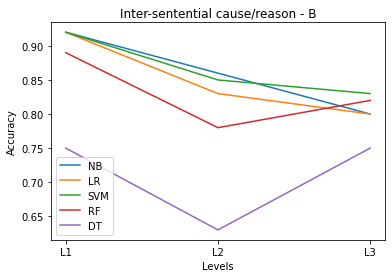

In [124]:
var.plot()
plt.xlabel("Levels")
plt.ylabel("Accuracy")
plt.title('Inter-sentential cause/reason - B') #We can change the title as we plot
positions = (0,1,2)
labels = ("L1", "L2", "L3")
plt.xticks(positions, labels)